# Coastal Kelvin Wave Test Case

simulating a coastal kelvin wave

In [4]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS_Ocean/"

In [5]:
include(CODE_ROOT * "mode_forward.jl")
include(CODE_ROOT * "mode_init.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [60]:
mpasOcean = MPAS_Ocean(false,
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/InertiaGravityWaveMesh",
                "base_mesh.nc", "mesh.nc", periodicity="Periodic")
ocn_init_routines_compute_max_level!(mpasOcean)

In [61]:
meanCoriolisParameterf = sum(mpasOcean.fCell) / mpasOcean.nCells

0.0001

In [62]:
meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)

1000.0

In [63]:
rossbyRadiusR = sqrt(gravity*meanFluidThicknessH)/meanCoriolisParameterf

989949.4936611665

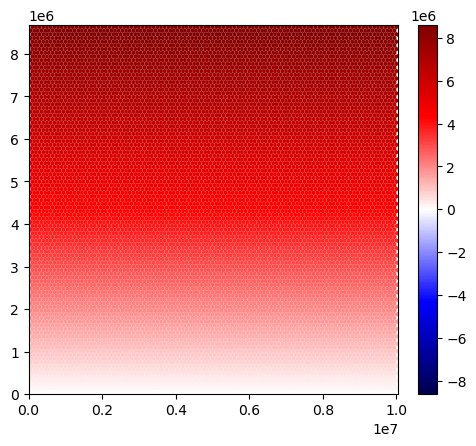

In [64]:
fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.yCell)
display(fig)

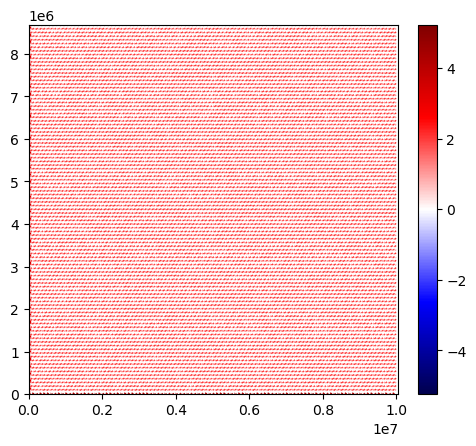

In [83]:
fig, ax, _, _ = edgeHeatMapMesh(mpasOcean, mpasOcean.angleEdge)
display(fig)


$ \pmatrix{\eta\\ u\\ v } = Real( \pmatrix{A\\ U\\ V} e^{i ( k_x x + k_y y - \omega t) } ) $

$ \frac{\partial \eta}{\partial t} = Imag(-w A e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial u}{\partial x} = Imag(k_x U e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial v}{\partial y} = Imag(k_y V e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial \eta}{\partial t} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} $



In [216]:
kx = 4 * 2*pi / mpasOcean.lX
U = 2.0e-3

ky = 3  * 2*pi / mpasOcean.lY
V = 4.5e-4

k = sqrt(kx^2 + ky^2)

w = sqrt(meanCoriolisParameterf^2 + gravity*meanFluidThicknessH*k^2)
A = (kx*U + ky*V) / w

kx, U, ky, V, w, A, kx*U + ky*V + w*A

(2.5132741228718346e-6, 0.002, 2.1765592370810614e-6, 0.00045, 0.0003439895026107, 1.7459834840446454e-5, 1.2011999804860293e-8)

In [217]:
maximum(mpasOcean.angleEdge)

5.235987755982989

In [218]:
function inertiaGravityInit!(mpasOcean, t=0; kx=kx, U=U, ky=ky, V=V, w=w, A=A)
    for iCell in 1:mpasOcean.nCells
        x = mpasOcean.xCell[iCell]
        y = mpasOcean.yCell[iCell]
        
        mpasOcean.sshCurrent[iCell] = A*cos(kx*x + ky*y - w*t)
    end
    
    for iEdge in 1:mpasOcean.nEdges
        x = mpasOcean.xEdge[iEdge]
        y = mpasOcean.yEdge[iEdge]
        
        u = U*cos(kx*x + ky*y - w*t)
        
        v = V*cos(kx*x + ky*y - w*t)
        
        theta = mpasOcean.angleEdge[iEdge]
        
        mpasOcean.normalVelocityCurrent[iEdge] = u*cos(theta) + v*sin(theta)
    end
end

inertiaGravityInit! (generic function with 2 methods)

In [219]:
inertiaGravityInit!(mpasOcean)

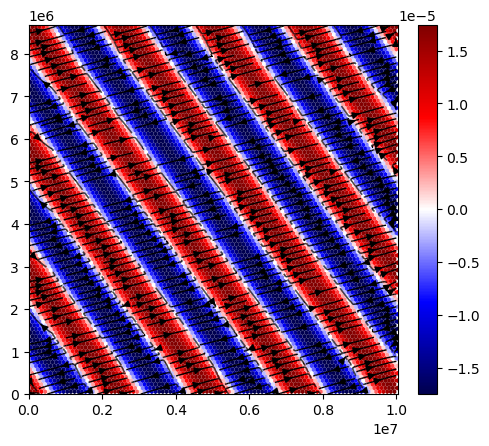

In [220]:
fig, ax, cbar, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
vectorStreamPlotMesh(mpasOcean, mpasOcean.normalVelocityCurrent, fig=fig, ax=ax, cbar=cbar, xbins=17, ybins=13)
display(fig)

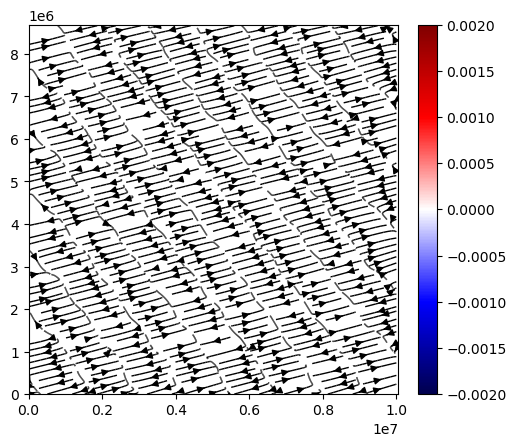

In [221]:
fig, ax, _, = vectorStreamPlotMesh(mpasOcean, mpasOcean.normalVelocityCurrent)
display(fig)

## define dt based on cfl condition

In [222]:
dt = 0.1 * minimum(mpasOcean.dcEdge) / sqrt(gravity*meanFluidThicknessH)

101.01525445521945

# Simulate wave

In [223]:
2*pi/(w*dt) # number of timesteps per cycle of wave

180.82052115587828

In [224]:
nFrames = 15

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))

for i in 1:nFrames
    forwardBackward!(mpasOcean, dt, dt*6)
    sshOverTime[i,:] .= mpasOcean.sshCurrent[:]
end

## animate simulation

In [225]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f5fec7ec6d0>

In [226]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [227]:
nFrames = 15

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))

t = 0

for i in 1:nFrames
    t += 6*dt
    inertiaGravityInit!(mpasOcean, t)
    sshOverTime[i,:] .= mpasOcean.sshCurrent[:]
end

## animate simulation

In [228]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f5fe7dea8b0>

In [229]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [233]:
nFrames = 15

normalVelocityOverTime = zeros(Float64, (nFrames, mpasOcean.nEdges))

t = 0

for i in 1:nFrames
    t += 6*dt
    inertiaGravityInit!(mpasOcean, t)
    normalVelocityOverTime[i,:] .= mpasOcean.normalVelocityCurrent[:]
end

In [237]:
cMax = maximum(abs.(sshOverTime))

fig, ax, cbar = vectorStreamPlotMesh(mpasOcean, normalVelocityOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
#     col.set_array(sshOverTime[i+1,:])
    vectorStreamPlotMesh(mpasOcean, normalVelocityOverTime[i+1,:], fig=fig, ax=ax, cbar=cbar)
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f5fd76919a0>

In [238]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>